# Advanced Machine Learning
## Project 1 - Optimization Algorithms
### Authors: Bartosz Grabek, Izabela Telejko, Grzegorz Zbrzeżny

- Booking (SGD might not be converging)
- Employee (SGD might not be converging)
- Churn (OK)
- Challenger (SUS)
- Jungle
- Water (OK)

In [1]:
import numpy as np
from datasets import *
from optim import GD, ADAM, IWLS

In [2]:
from utils.train_functions import cv
from utils.plots import (
    plot_figures_for_cv,
    plot_acc_boxplots
)

In [3]:
dataset_names = [
    "booking", "churn", "diabetes", "employee", "challenger", "jungle", "ionosphere", "water", "seeds", "sonar"
]
datasets = {
    name: load_dataset(name) for name in dataset_names
}

In [5]:
from datasets.preprocess_helpers import split_with_preprocess

print(help(split_with_preprocess))
len(split_with_preprocess(datasets['booking']))

Help on function split_with_preprocess in module datasets.preprocess_helpers:

split_with_preprocess(dataset: datasets.dataset_model.Dataset, interactions: bool = False, test_size: int = 0.2, random_state: int = None, vif=True) -> tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray]
    Train test split for given data frame including some additional preprocessing,
    removal of multicolinear columns using VIF, generating interactions, and adding column of ones.

None
Removing multicolinear columns in booking dataset...


4

### TODO:
Some columns in X_challenger and X_jungle have only 0 values

In [6]:
l_vals_splits_dict, acc_vals_splits_dict = cv(datasets["booking"], n_splits=2)

CV split 1
Removing multicolinear columns in booking dataset...


ADAM:   9%|▉         | 45/500 [00:40<06:53,  1.10it/s]


Balanced accuracy of iwls is: 0.7566324347454001
Balanced accuracy of sgd is: 0.6322742832691485
Balanced accuracy of adam is: 0.7548352588789047
Balanced accuracy of lr is: 0.7607509627727855
Balanced accuracy of qda is: 0.5
Balanced accuracy of lda is: 0.746624946512623
Balanced accuracy of dt is: 0.7966730851519042
Balanced accuracy of rf is: 0.7453679931536158
CV split 2
Removing multicolinear columns in booking dataset...


ADAM:   6%|▌         | 30/500 [00:27<07:04,  1.11it/s]


Balanced accuracy of iwls is: 0.7607983396490783
Balanced accuracy of sgd is: 0.6722876100786824
Balanced accuracy of adam is: 0.7639110623787615
Balanced accuracy of lr is: 0.754965444756005
Balanced accuracy of qda is: 0.5
Balanced accuracy of lda is: 0.7496548479886125
Balanced accuracy of dt is: 0.7960926790168121
Balanced accuracy of rf is: 0.7440683037114852


In [8]:
plot_acc_boxplots(sgd_acc_list, adam_acc_list, iwls_acc_list)

NameError: name 'sgd_acc_list' is not defined

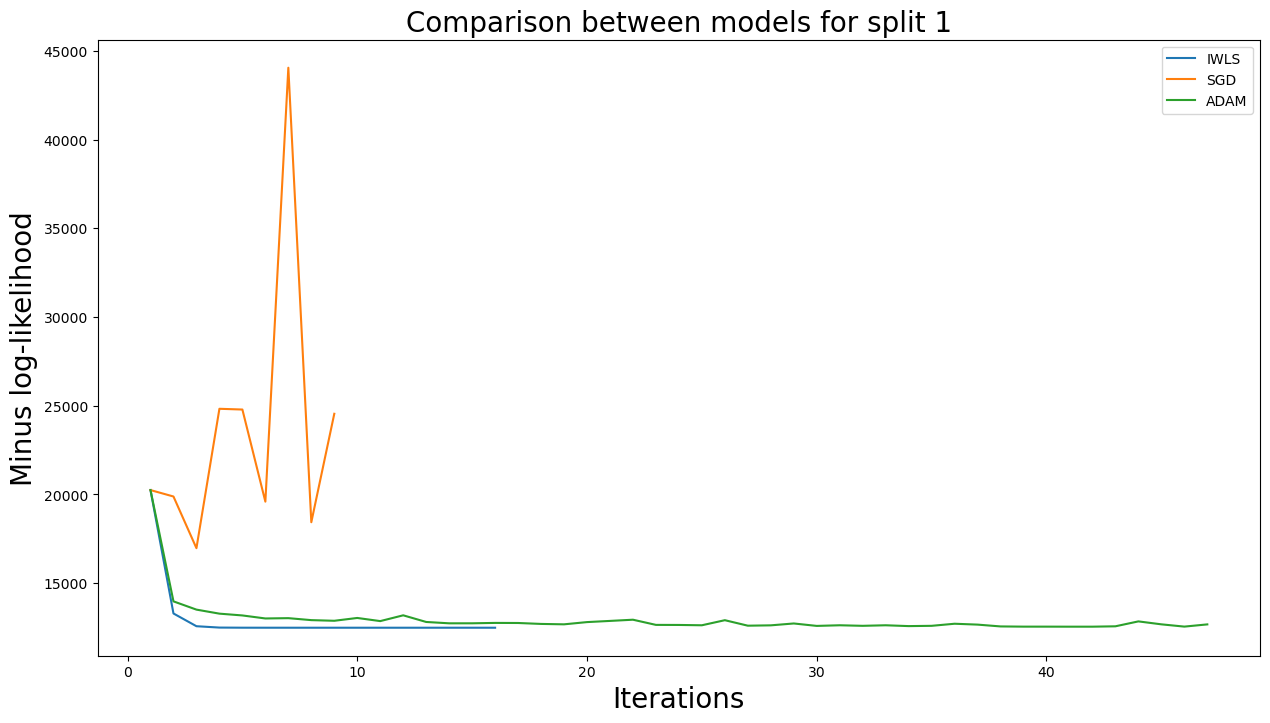

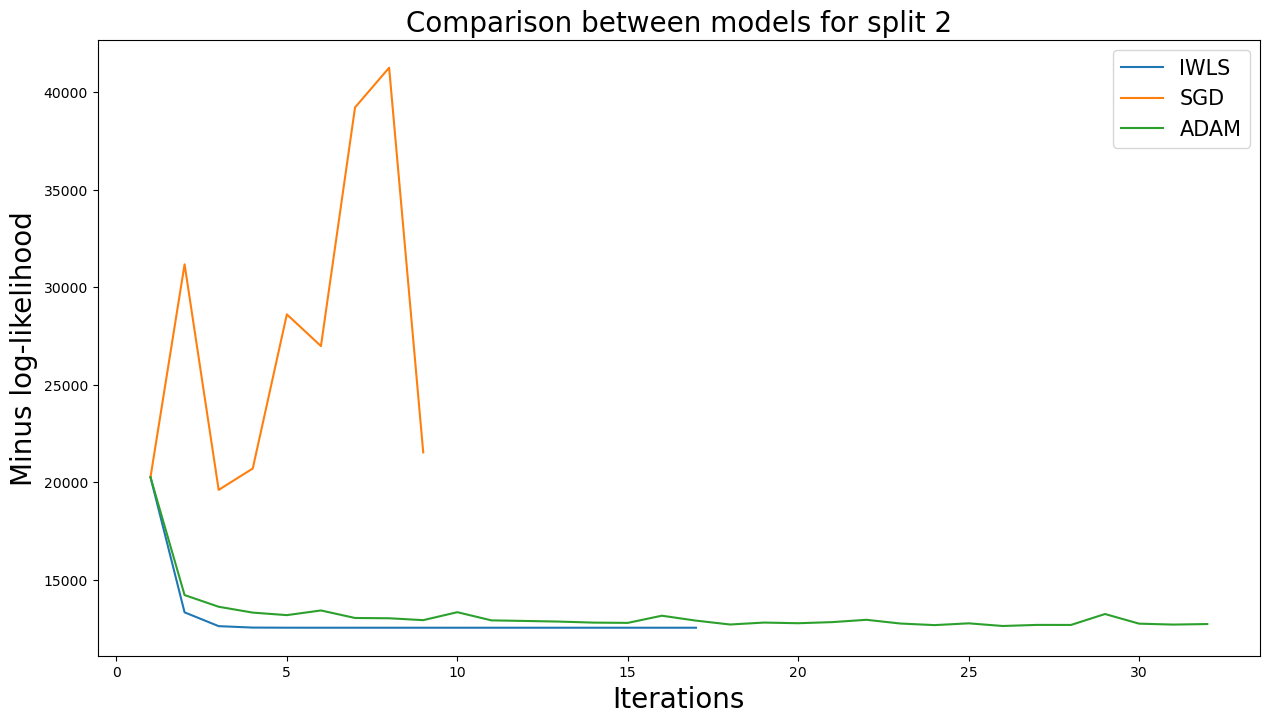

In [7]:
plot_figures_for_cv(l_vals_splits_dict["iwls"], l_vals_splits_dict["sgd"], l_vals_splits_dict["adam"])

### Data generated from logistic model

In [8]:
beta1 = 2

n1 = 1000
x1 = np.random.exponential(1, size=n1)

n2 = 1000
x2 = np.random.exponential(1/(beta1+1), size=n2)

X = np.expand_dims(np.concatenate((x1, x2), axis=0), axis=1)
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
y = np.expand_dims(np.concatenate((np.ones((1, n1)), np.zeros((1, n2))), axis=1)[0], 1)

In [9]:
pi = n1 / (n1 + n2)
b0 = -np.log((1 + beta1) * ((1-pi)/pi))

In [12]:
iwls = IWLS(n_iter=100)
gd = GD(learning_rate=0.0002, n_epoch=200)
adam = ADAM(learning_rate=0.0002, n_epoch=200)

l_iwls_vals, best_beta_iwls = iwls.fit(X, y)
l_sgd_vals, best_beta_sgd = gd.fit(X, y)
l_adam_vals, best_beta_adam = adam.fit(X, y)

ADAM:  77%|███████▋  | 154/200 [00:08<00:02, 17.96it/s]


In [13]:
print(f"Theoretical betas: b0: {b0}, b1: {beta1}" )
print(f"Empirical betas for SGD without optimizers: b0: {best_beta_sgd[0]}, b1: {best_beta_sgd[1]}")
print(f"Empirical betas for SGD with ADAM: b0: {best_beta_adam[0]}, b1: {best_beta_adam[1]}")
print(f"Empirical betas for IWLS: b0: {best_beta_iwls[0][0]}, b1: {best_beta_iwls[1][0]}")

Theoretical betas: b0: -1.0986122886681096, b1: 2
Empirical betas for SGD without optimizers: b0: -1.0475160173526807, b1: 1.907610665629832
Empirical betas for SGD with ADAM: b0: -1.1264957419700161, b1: 2.0607491263048825
Empirical betas for IWLS: b0: -1.1282736648847402, b1: 2.061834363982213


# Classification Performance Comparison for Datasets with and without interactions